In [1]:
import sys
import torch

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import trange
from sklearn.manifold import TSNE
from geoopt import linalg

sys.path.append("./lib/data")
from get_data import get_data, get_cov

sys.path.append("./lib/spdnet")
import nn as nn_spd
from optimizers import MixOptimizer

sys.path.append("./lib")
from swspd import sliced_wasserstein_spd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

### Data

In [3]:
subject = 1
Xs, ys = get_data(subject, True, "./dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(subject, False, "./dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1

In [4]:
print(Xs.shape, cov_Xs.shape, Xt.shape, cov_Xt.shape)

(273, 22, 1750) torch.Size([273, 1, 43, 22, 22]) (281, 22, 1750) torch.Size([281, 1, 43, 22, 22])


### NNs

In [5]:
class SPDNet(nn.Module):
    def __init__(self, d):
        super().__init__()
        dim = d
        dim1 = d
        dim2 = d
        dim3 = d
#         dim1=200; dim2=100; dim3=50
                
        self.re = nn_spd.ReEig()
        self.bimap1 = nn_spd.BiMap(1,1,dim,dim1)
        self.batchnorm1 = nn_spd.BatchNormSPD(dim1)
        self.bimap2 = nn_spd.BiMap(1,1,dim1,dim2)
        self.batchnorm2 = nn_spd.BatchNormSPD(dim2)
        self.bimap3 = nn_spd.BiMap(1,1,dim2,dim3)
        self.batchnorm3 = nn_spd.BatchNormSPD(dim3)
#         self.logeig = nn_spd.LogEig() ## projection on Symmetric matrices

#         self.linear=nn.Linear(dim3**2,classes).double()
        
    def forward(self,x):
        x_spd = self.re(self.batchnorm1(self.bimap1(x)))
#         print("0", torch.any(torch.linalg.eigh(x_spd)[0]<0))
        x_spd = self.re(self.batchnorm2(self.bimap2(x_spd)))
#         print("1", torch.any(torch.linalg.eigh(x_spd)[0]<0))
        x_spd = self.batchnorm3(self.bimap3(x_spd))
#         print("2", torch.any(torch.linalg.eigh(x_spd)[0]<0))

#         x_vec = self.logeig(x_spd) #.view(x_spd.shape[0],-1)
#         y = self.linear(x_vec)
#         print("x_vec", torch.any(torch.linalg.eigh(x_vec)[0]<0))

        return x_spd

In [6]:
model = SPDNet(22).to(device)

In [7]:
print(model)

SPDNet(
  (re): ReEig()
  (bimap1): BiMap()
  (batchnorm1): BatchNormSPD()
  (bimap2): BiMap()
  (batchnorm2): BatchNormSPD()
  (bimap3): BiMap()
  (batchnorm3): BatchNormSPD()
)


In [8]:
out = model(torch.tensor(cov_Xs)[:,:,0])
out.shape

/home/clement/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
./lib/spdnet/functional.py:68: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2910.)
  s, U[i,j] = th.eig(P[i,j],True)


torch.Size([273, 1, 22, 22])

In [9]:
torch.tensor(cov_Xs)[:,:,0].shape

/home/clement/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([273, 1, 22, 22])

In [10]:
# class mlp_spd(nn.Module):
#     def __init__(self, d_in, nh, d_out, n_layers):
#         super().__init__()
#         self.layers = nn.ModuleList()
#         self.layers.append(nn.Linear(d_in,nh))
#         for i in range(n_layers):
#             self.layers.append(nn.Linear(nh,nh))
#         self.layers.append(nn.Linear(nh,d_out))

#         self.logeig = nn_spd.LogEig() ## projection on Symmetric matrices


#     def forward(self, x_spd):
#         x = self.logeig(x_spd).view(x_spd.shape[0], -1)
        
#         for layer in self.layers:
#             x = F.leaky_relu(layer(x),0.2)
#         return F.softmax(x, dim=-1)

In [11]:
class mlp_spd(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
#         self.layers = nn.ModuleList()
#         self.layers.append(nn.Linear(d_in,nh))
#         for i in range(n_layers):
#             self.layers.append(nn.Linear(nh,nh))
#         self.layers.append(nn.Linear(nh,d_out))

        self.dense1 = nn.Linear(d_in, 500)
        self.dense2 = nn.Linear(500, 200)
        self.dense3 = nn.Linear(200,100)
        self.dense4 = nn.Linear(100, d_out)
        self.logeig = nn_spd.LogEig() ## projection on Symmetric matrices


    def forward(self, x_spd):
        x = self.logeig(x_spd).view(x_spd.shape[0], -1)
        
#         for layer in self.layers:
#             x = F.leaky_relu(layer(x),0.2)

        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = F.relu(self.dense3(x))
        x = F.relu(self.dense4(x))
            
        return F.softmax(x, dim=-1)

### Training

- Need to average over all frequences?
- Add a regularization parameter in front of SW

In [ ]:
epochs = 1000
num_projs = 500
d = 22
n_classes = 4
lr = 1e-1

freq = 0

criterion = nn.CrossEntropyLoss()

model = SPDNet(d).to(device)
classifier = mlp_spd(d*d, 3, n_classes, 5).to(device)

optimizer = MixOptimizer(list(model.parameters()) + list(classifier.parameters()), lr=lr)

L_loss = []
L_sw = []
L_classif = []

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,freq])
    zt = model(cov_Xt[:,:,freq])
    
    y_hat = classifier(zs.type(torch.float32))
#     y_hat = classifier(zs.type(torch.float32).reshape(-1, d*d))
#     print(y_hat.shape, zs.shape)
    
    align_loss = sliced_wasserstein_spd(zs[:,0], zt[:,0], num_projs, device, p=2)
    classif_loss = criterion(y_hat, ys)
    
    loss = align_loss + classif_loss
    loss.backward()
    
#     print(loss.item(), align_loss.item(), classif_loss.item())
#     print(torch.any(torch.isnan(zs)), torch.any(torch.isnan(zt)))
    
    L_loss.append(loss.item())
    L_sw.append(align_loss.item())
    L_classif.append(classif_loss.item())
    
    optimizer.step()
    optimizer.zero_grad()
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"sw = {align_loss.item():.3f} " + f"bce = {classif_loss.item():.3f}")
#     print(loss.item(), align_loss.item(), classif_loss.item())


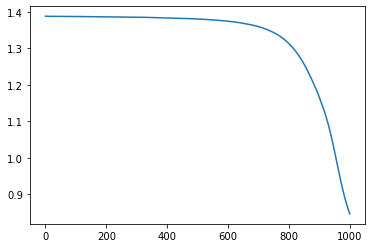

In [119]:
plt.plot(L_loss)
plt.show()

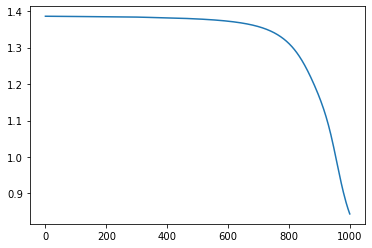

In [120]:
plt.plot(L_classif)
plt.show()

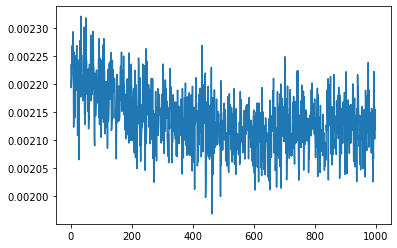

In [121]:
plt.plot(L_sw)
plt.show()

In [122]:
L_loss

[1.3883336741427799,
 1.3882840641917304,
 1.3882847379381038,
 1.388285878666995,
 1.3883256316676356,
 1.3882755675452296,
 1.3882980995023937,
 1.3883155370372209,
 1.3882681323816313,
 1.3881206654233778,
 1.3881589390818567,
 1.3882287150193262,
 1.3881638094762403,
 1.3880912854985339,
 1.3881691081518532,
 1.3881828240985459,
 1.3881613124479637,
 1.3881053538126904,
 1.3881183378742536,
 1.3881703529421854,
 1.3880909195090012,
 1.3881051016671244,
 1.3879889255206728,
 1.3881170495888395,
 1.3880726286576714,
 1.3880182459201453,
 1.3879177595157108,
 1.388026184520503,
 1.38806229818459,
 1.3880434941335713,
 1.3881043509890931,
 1.3880447125201394,
 1.3879918256395785,
 1.388128976027953,
 1.3880146349296407,
 1.3880113127018263,
 1.3880039300054612,
 1.3879821397356906,
 1.3879622547466137,
 1.3879413105474943,
 1.3879864219388223,
 1.388010395452489,
 1.3879478339172857,
 1.3880480055108437,
 1.3879822186285198,
 1.3878794285627865,
 1.387947935585292,
 1.3878501087422874,

In [123]:
y_test = classifier(zt.type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 36.65480422973633%


In [124]:
torch.argmax(y_test, dim=-1)

tensor([0, 1, 2, 1, 0, 0, 2, 3, 2, 2, 2, 2, 0, 2, 3, 3, 2, 2, 2, 2, 2, 1, 3, 3,
        1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2, 3, 3, 2, 2, 3, 2, 0, 1, 3, 0,
        1, 2, 1, 2, 1, 3, 0, 1, 0, 2, 2, 3, 0, 2, 1, 0, 2, 2, 0, 1, 2, 1, 1, 1,
        0, 1, 0, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 3, 3, 1, 2, 0, 0, 2, 1, 0, 1,
        1, 3, 2, 2, 2, 0, 1, 2, 0, 2, 2, 3, 2, 3, 2, 1, 1, 1, 2, 3, 0, 1, 0, 1,
        1, 0, 0, 3, 0, 0, 1, 1, 3, 1, 3, 3, 0, 1, 0, 3, 0, 0, 3, 3, 2, 2, 1, 1,
        2, 2, 3, 0, 1, 1, 3, 2, 0, 3, 0, 2, 1, 2, 3, 1, 3, 3, 0, 2, 1, 2, 3, 1,
        2, 0, 1, 2, 0, 0, 1, 2, 1, 3, 3, 2, 3, 1, 2, 0, 1, 0, 2, 2, 3, 0, 0, 1,
        3, 0, 0, 3, 2, 1, 2, 2, 0, 3, 3, 2, 2, 2, 0, 2, 3, 2, 2, 3, 0, 2, 2, 2,
        2, 2, 2, 0, 3, 0, 0, 1, 0, 3, 3, 0, 1, 1, 0, 3, 2, 3, 1, 3, 1, 3, 2, 0,
        0, 0, 0, 2, 2, 1, 1, 1, 1, 3, 0, 0, 1, 3, 3, 0, 3, 2, 3, 1, 2, 2, 2, 2,
        0, 2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 0, 0])

In [125]:
yt

tensor([0, 1, 1, 0, 1, 0, 1, 2, 1, 3, 0, 2, 1, 0, 3, 3, 3, 3, 2, 1, 0, 0, 2, 3,
        0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 2, 1, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 1,
        0, 0, 1, 3, 1, 2, 0, 0, 0, 3, 1, 1, 0, 0, 2, 0, 3, 3, 2, 0, 3, 3, 1, 3,
        3, 1, 0, 1, 2, 2, 2, 3, 2, 0, 3, 1, 2, 1, 2, 3, 1, 2, 0, 0, 0, 3, 1, 0,
        2, 0, 2, 1, 3, 0, 2, 2, 0, 2, 1, 3, 3, 3, 2, 0, 3, 1, 3, 1, 0, 1, 0, 2,
        2, 0, 2, 3, 3, 1, 0, 1, 3, 1, 3, 2, 1, 1, 1, 2, 3, 0, 1, 3, 0, 2, 2, 3,
        0, 0, 2, 1, 3, 3, 3, 1, 0, 2, 1, 3, 0, 3, 2, 1, 3, 3, 0, 1, 1, 2, 3, 1,
        0, 0, 3, 1, 0, 2, 1, 1, 0, 3, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 2, 1, 2,
        3, 0, 3, 0, 0, 1, 3, 2, 1, 3, 2, 3, 2, 3, 1, 1, 3, 0, 1, 1, 1, 2, 3, 0,
        3, 0, 2, 0, 3, 0, 2, 0, 1, 2, 2, 3, 0, 1, 3, 1, 2, 2, 0, 3, 1, 3, 0, 0,
        2, 2, 1, 3, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 2, 3, 0, 1, 2, 1, 0, 3,
        0, 3, 0, 0, 0, 0, 2, 2, 3, 1, 2, 2, 2, 3, 2, 0, 2])

In [126]:
y_test

tensor([[0.3694, 0.2635, 0.3210, 0.0462],
        [0.0930, 0.5225, 0.2671, 0.1174],
        [0.1550, 0.0242, 0.7853, 0.0355],
        ...,
        [0.1515, 0.2837, 0.4689, 0.0959],
        [0.6851, 0.2232, 0.0782, 0.0135],
        [0.7563, 0.1016, 0.1304, 0.0117]], grad_fn=<SoftmaxBackward0>)

In [67]:
epochs = 1000
num_projs = 500
d = 22
n_classes = 4
lr = 1e-1

freq = 0

criterion = nn.CrossEntropyLoss()

model = SPDNet(d).to(device)
classifier = mlp_spd(d*d, 3, n_classes, 5).to(device)

optimizer = MixOptimizer(list(model.parameters()) + list(classifier.parameters()), lr=lr,
                        momentum=0.9, weight_decay=5e-4)

L_loss = []
L_sw = []
L_classif = []
L_acc = []

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,freq])
    zt = model(cov_Xt[:,:,freq])
    
    y_hat = classifier(zs.type(torch.float32))
    
    align_loss = sliced_wasserstein_spd(zs[:,0], zt[:,0], num_projs, device, p=2)
    classif_loss = criterion(y_hat, ys)
    
    loss = align_loss + classif_loss
    loss.backward()
    
    L_loss.append(loss.item())
    L_sw.append(align_loss.item())
    L_classif.append(classif_loss.item())
    
    optimizer.step()
    optimizer.zero_grad()
    
    with torch.no_grad():
        y_test = classifier(zt.type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        
        L_acc.append(acc.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"sw = {align_loss.item():.3f} " 
                         + f"bce = {classif_loss.item():.3f} " + f"acc = {acc.item():.3f}")
#     print(loss.item(), align_loss.item(), classif_loss.item())


100%|██████████| 1000/1000 [54:53<00:00,  3.29s/it, loss = 0.909 sw = 0.002 bce = 0.907 acc = 31.673]


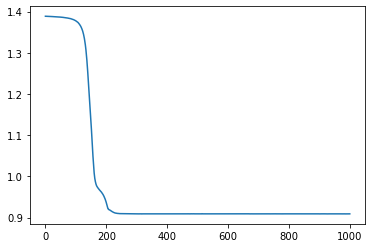

In [68]:
plt.plot(L_loss)
plt.show()

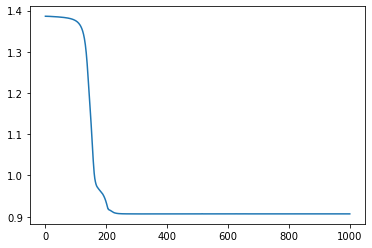

In [69]:
plt.plot(L_classif)
plt.show()

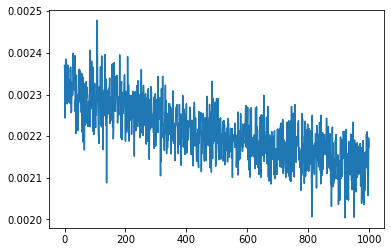

In [70]:
plt.plot(L_sw)
plt.show()

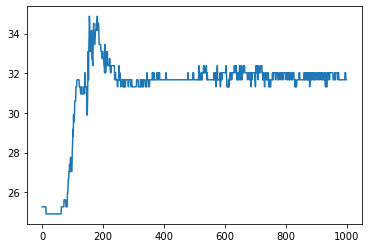

In [71]:
plt.plot(L_acc)
plt.show()

In [72]:
y_test = classifier(zt.type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 31.672597885131836%


In [73]:
log_Xs = linalg.sym_logm(zs.detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(zt.detach().cpu()).reshape(-1, d*d)

data = torch.cat([log_Xs, log_Xt], dim=0)
X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(data.numpy())

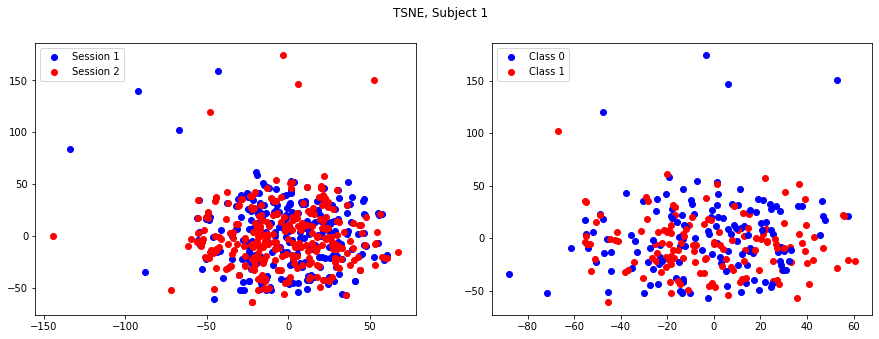

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")

ax[0].legend()
ax[1].legend()

plt.suptitle("TSNE, Subject 1")
plt.show()

In [ ]:
## TO DO : RELANCER AVEC 10000 EPOQUES

In [12]:
epochs = 5000
num_projs = 500
d = 22
n_classes = 4
lr = 1e-1

freq = 0

criterion = nn.CrossEntropyLoss()

model = SPDNet(d).to(device)
classifier = mlp_spd(d*d, 3, n_classes, 5).to(device)

optimizer = MixOptimizer(list(model.parameters()) + list(classifier.parameters()), lr=lr)
#                         ,momentum=0.9, weight_decay=5e-4)

L_loss = []
L_sw = []
L_classif = []
L_acc = []

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,freq])
    zt = model(cov_Xt[:,:,freq])
    
    y_hat = classifier(zs.type(torch.float32))
    
    align_loss = sliced_wasserstein_spd(zs[:,0], zt[:,0], num_projs, device, p=2)
    classif_loss = criterion(y_hat, ys)
    
    loss = align_loss + classif_loss
    loss.backward()
    
    L_loss.append(loss.item())
    L_sw.append(align_loss.item())
    L_classif.append(classif_loss.item())
    
    optimizer.step()
    optimizer.zero_grad()
    
    with torch.no_grad():
        y_test = classifier(zt.type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        
        L_acc.append(acc.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"sw = {align_loss.item():.3f} " 
                         + f"bce = {classif_loss.item():.3f} " + f"acc = {acc.item():.3f}")
#     print(loss.item(), align_loss.item(), classif_loss.item())


100%|██████████| 5000/5000 [3:44:18<00:00,  2.69s/it, loss = 0.746 sw = 0.002 bce = 0.744 acc = 41.993]  


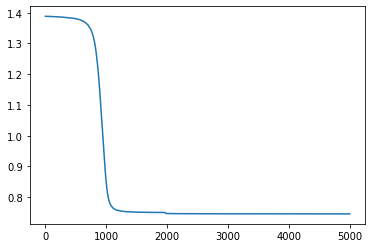

In [13]:
plt.plot(L_loss)
plt.show()

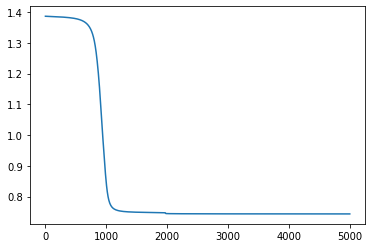

In [14]:
plt.plot(L_classif)
plt.show()

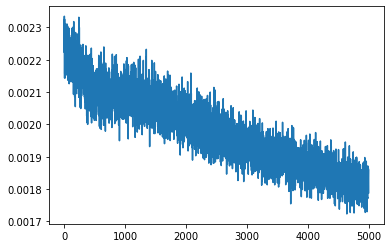

In [15]:
plt.plot(L_sw)
plt.show()

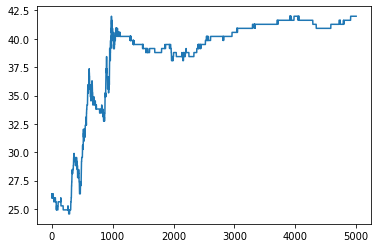

In [16]:
plt.plot(L_acc)
plt.show()

In [17]:
y_test = classifier(zt.type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 41.992881774902344%


In [18]:
log_Xs = linalg.sym_logm(zs.detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(zt.detach().cpu()).reshape(-1, d*d)

data = torch.cat([log_Xs, log_Xt], dim=0)
X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(data.numpy())

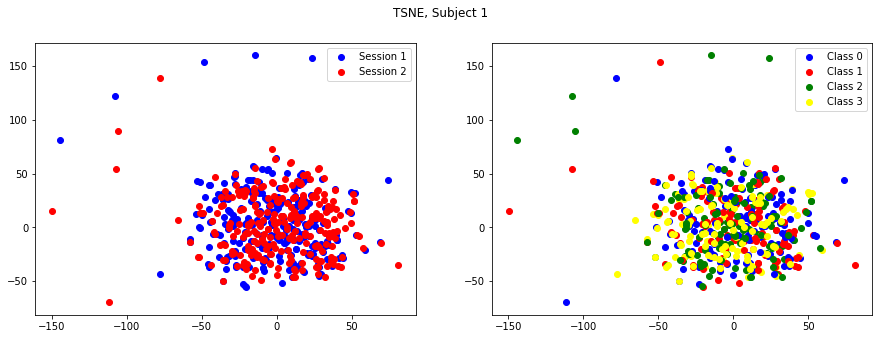

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

ax[0].legend()
ax[1].legend()

plt.suptitle("TSNE, Subject 1")
plt.show()

### Baseline: Classifier on source

In [34]:
epochs = 10000
num_projs = 500
d = 22
n_classes = 4
lr = 1e-2

freq = 0

criterion = nn.CrossEntropyLoss()

classifier = mlp_spd(d*d, 3, n_classes, 5).to(device)

optimizer = MixOptimizer(list(classifier.parameters()), lr=lr, momentum=0.9, weight_decay=5e-4)

L_loss = []
L_acc = []

pbar = trange(epochs)

for e in pbar:    
    y_hat = classifier(cov_Xs[:,:,freq].type(torch.float32))
    classif_loss = criterion(y_hat, ys)
    
    loss = classif_loss
    loss.backward()
    
    L_loss.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()
    
#     pbar.set_postfix_str(f"loss = {loss.item():.3f} ")
#     print(loss.item(), align_loss.item(), classif_loss.item())

    with torch.no_grad():
        y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        
        L_acc.append(acc.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"acc = {acc.item():.3f}")


100%|██████████| 10000/10000 [23:20<00:00,  7.14it/s, loss = 0.915 acc = 35.231]


In [35]:
y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 35.23131561279297%


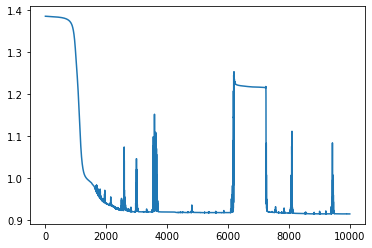

In [36]:
plt.plot(L_loss)
plt.show()

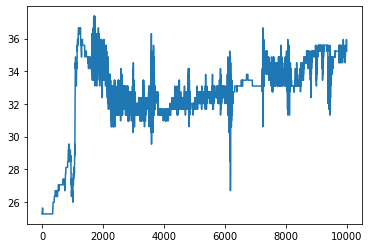

In [37]:
plt.plot(L_acc)
plt.show()

In [38]:
log_Xs = linalg.sym_logm(cov_Xs[:,:,freq].detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,:,freq].detach().cpu()).reshape(-1, d*d)

In [40]:
data = torch.cat([log_Xs, log_Xt], dim=0)

In [41]:
X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(data.numpy())

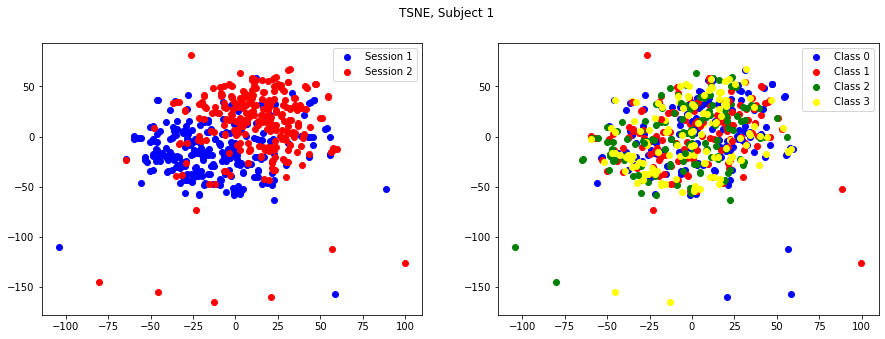

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

ax[0].legend()
ax[1].legend()

plt.suptitle("TSNE, Subject 1")
plt.show()

In [17]:
y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 33.807830810546875%


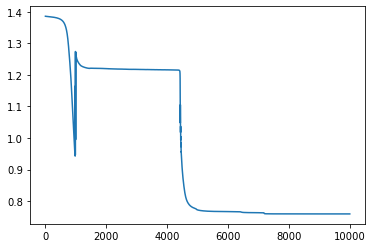

In [18]:
plt.plot(L_loss)
plt.show()

In [40]:
log_Xs = linalg.sym_logm(cov_Xs[:,:,freq].detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,:,freq].detach().cpu()).reshape(-1, d*d)

In [41]:
log_Xs.dtype

torch.float64

In [44]:
data = torch.cat([log_Xs, log_Xt], dim=0)

In [46]:
X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(data.numpy())

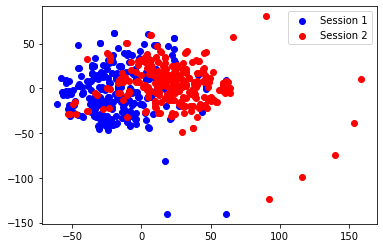

In [58]:
plt.scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
plt.scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")
plt.legend()
plt.show()

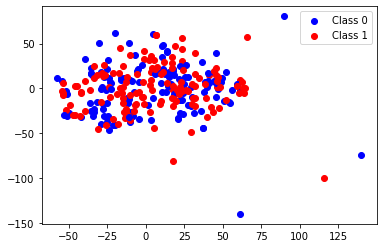

In [57]:
plt.scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
plt.scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")

plt.scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
plt.scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")

plt.legend()
plt.show()

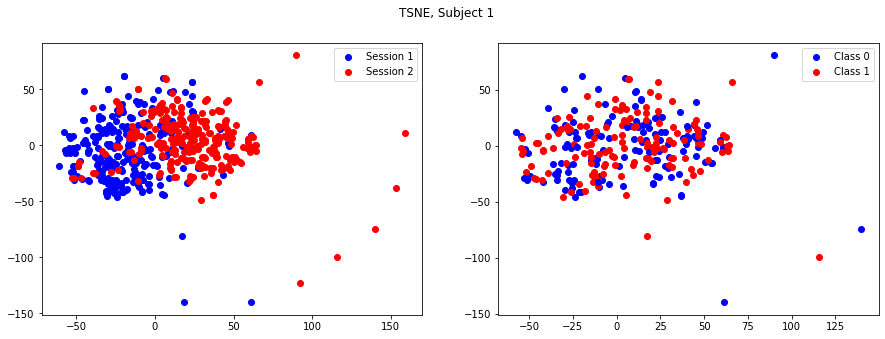

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

ax[0].legend()
ax[1].legend()

plt.suptitle("TSNE, Subject 1")
plt.show()

### Golden Score: Classifier on target

In [108]:
epochs = 10000
# num_projs = 500
d = 22
n_classes = 4
lr = 1e-1

freq = 0

criterion = nn.CrossEntropyLoss()

classifier = mlp_spd(d*d, 100, n_classes, 5).to(device)

optimizer = MixOptimizer(list(classifier.parameters()), lr=lr)

L_loss = []

pbar = trange(epochs)

for e in pbar:    
    y_hat = classifier(cov_Xt[:,:,freq].type(torch.float32))
    classif_loss = criterion(y_hat, yt)
    
    loss = classif_loss
    loss.backward()
    
    L_loss.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f} ")
#     print(loss.item(), align_loss.item(), classif_loss.item())


100%|██████████| 10000/10000 [20:28<00:00,  8.14it/s, loss = 0.913 ]


In [109]:
y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 74.37722778320312%


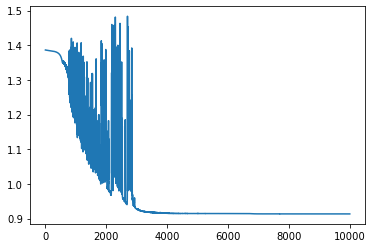

In [110]:
plt.plot(L_loss)
plt.show()

In [111]:
torch.argmax(y_test, dim=-1)

tensor([0, 1, 1, 0, 1, 0, 1, 2, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0,
        0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 0, 1, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 1,
        0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 2, 2, 2, 0, 2, 0, 0, 1, 2, 1, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0,
        2, 0, 2, 1, 0, 0, 2, 2, 0, 2, 1, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 0, 2,
        2, 0, 2, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 2, 2, 0,
        0, 0, 2, 1, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 2, 0, 1,
        0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 2, 1, 2,
        0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 2, 0, 1, 1, 0, 0, 1, 1, 1, 2, 0, 0,
        0, 0, 2, 0, 0, 0, 2, 0, 1, 2, 2, 0, 0, 1, 0, 1, 2, 2, 0, 0, 1, 2, 0, 0,
        2, 2, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 2, 0, 0, 1, 2, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 2, 2, 2, 0, 2, 0, 2])

In [112]:
yt

tensor([0, 1, 1, 0, 1, 0, 1, 2, 1, 3, 0, 2, 1, 0, 3, 3, 3, 3, 2, 1, 0, 0, 2, 3,
        0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 2, 1, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 1,
        0, 0, 1, 3, 1, 2, 0, 0, 0, 3, 1, 1, 0, 0, 2, 0, 3, 3, 2, 0, 3, 3, 1, 3,
        3, 1, 0, 1, 2, 2, 2, 3, 2, 0, 3, 1, 2, 1, 2, 3, 1, 2, 0, 0, 0, 3, 1, 0,
        2, 0, 2, 1, 3, 0, 2, 2, 0, 2, 1, 3, 3, 3, 2, 0, 3, 1, 3, 1, 0, 1, 0, 2,
        2, 0, 2, 3, 3, 1, 0, 1, 3, 1, 3, 2, 1, 1, 1, 2, 3, 0, 1, 3, 0, 2, 2, 3,
        0, 0, 2, 1, 3, 3, 3, 1, 0, 2, 1, 3, 0, 3, 2, 1, 3, 3, 0, 1, 1, 2, 3, 1,
        0, 0, 3, 1, 0, 2, 1, 1, 0, 3, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 2, 1, 2,
        3, 0, 3, 0, 0, 1, 3, 2, 1, 3, 2, 3, 2, 3, 1, 1, 3, 0, 1, 1, 1, 2, 3, 0,
        3, 0, 2, 0, 3, 0, 2, 0, 1, 2, 2, 3, 0, 1, 3, 1, 2, 2, 0, 3, 1, 3, 0, 0,
        2, 2, 1, 3, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 2, 3, 0, 1, 2, 1, 0, 3,
        0, 3, 0, 0, 0, 0, 2, 2, 3, 1, 2, 2, 2, 3, 2, 0, 2])

In [113]:
y_test

tensor([[1.0000e+00, 3.0477e-07, 3.0477e-07, 3.0477e-07],
        [7.2193e-05, 9.9978e-01, 7.2193e-05, 7.2193e-05],
        [4.5796e-05, 9.9986e-01, 4.5796e-05, 4.5796e-05],
        ...,
        [1.5903e-05, 1.5903e-05, 9.9995e-01, 1.5903e-05],
        [9.9999e-01, 3.6616e-06, 3.6616e-06, 3.6616e-06],
        [5.3785e-05, 5.3785e-05, 9.9984e-01, 5.3785e-05]],
       grad_fn=<SoftmaxBackward0>)

In [114]:
print(classifier)

mlp_spd(
  (dense1): Linear(in_features=484, out_features=500, bias=True)
  (dense2): Linear(in_features=500, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=100, bias=True)
  (dense4): Linear(in_features=100, out_features=4, bias=True)
  (logeig): LogEig()
)
